In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import tensorflow as tf

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils


2024-01-31 19:03:27.317575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 19:03:27.317639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 19:03:27.318838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 19:03:27.327232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 19:03:28.242110: W tensorflow/compiler/tf2

In [2]:
# model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240112_140537-85ahbucq/files\model_85ahbucq.hdf5')
# model_ew.save('models/ew_localizer.hdf5')


In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2_custom/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:40]}

In [ ]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

ew_input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Argument of Periapsis (deg)', 'Longitude (deg)', 'Altitude (m)']
#ew_input_features = ['Eccentricity', 'Longitude (deg)', 'Latitude (deg)']

ns_input_features = ['Eccentricity', 'Semimajor Axis (m)',  'Inclination (deg)', 'Latitude (deg)', 'Longitude (deg)']


utils.set_random_seed(42)
# ds_gen_ew = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ew_input_features,
#                                       with_labels=True, pad_location_labels=0,
#                                       nonbinary_padding=[120.0, 80.0, 60.0, 40.0, 20.0],
#                                       train_val_split=0.8, input_stride=4, padding='none',
#                                       transform_features=True,
#                                       input_history_steps=48, input_future_steps=48, seed=69)

ds_gen_ns = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ns_input_features,
                                      with_labels=True, pad_location_labels=0,
                                      nonbinary_padding=[120.0, 80.0, 60.0, 40.0, 20.0],
                                      train_val_split=0.8, input_stride=4, padding='none',
                                      transform_features=True,
                                      input_history_steps=64, input_future_steps=64, seed=69)

=========================Creating Generator=======================
Seed: 69
nTrain: 1360 nVal: 340 (0.80)
Padding: none
Scaling: True 
Horizons: 48-48 @ stride 4
Sin-Transformed features: ['Argument of Periapsis (deg)']
Padding node locations in non-binary fashion ([20.0, 40.0, 60.0, 80.0, 120.0, 80.0, 60.0, 40.0, 20.0])
=========================Finished Generator=======================


In [ ]:
train_ew, val_ew = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location'], shuffle=True, stride=1)

print(train_ew.element_spec)

#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,32],[32,16]], dense_layers=[64,32], l2_reg=0.0001, mixed_dropout=0.1, lr_scheduler=[30000,0.8], seed=0)
model_ew = prediction_models.Dense_NN(val_ew, conv1d_layers=[], dense_layers=[256,128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#model_ew = prediction_models.LSTM_NN(val_ew, input_dropout=0.0, mixed_dropout=0.1, lstm_layers=[128,64], dense_layers=[32,16], l2_reg=0.0001, lr_scheduler=[], seed=1)

train_ew = train_ew.map(lambda x,y:(x,y['EW_Node_Location']))
val_ew = val_ew.map(lambda x,y:(x,y['EW_Node_Location'])) # temporary fix to allow class weights

model_ew.summary()
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=20, verbose=1, plot_hist=True, 
                    class_weight={0: 1.0, 1: 2.0}, 
                    callbacks=[])
#model_ew.model.save('models/ew_localizer.hdf5')

2024-01-31 17:49:40.295423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 17:49:40.331325: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 17:49:40.331399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 17:49:40.333396: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 17:49:40.333466: I external/local_xla/xla/stream_executor

(TensorSpec(shape=(None, 24, 5), dtype=tf.float64, name=None), {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 24, 5)]           0         
                                                                 
 conv1d (Conv1D)             (None, 19, 32)            992       
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 32)            6176      
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 16)                7184      
                                                                 
 dropout (Dropout)           (None, 16)          

2024-01-31 17:49:47.783201: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2712998400 exceeds 10% of free system memory.


Epoch 1/15


2024-01-31 17:49:50.294025: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-31 17:49:51.771847: I external/local_xla/xla/service/service.cc:168] XLA service 0x9cdfdec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-31 17:49:51.771900: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-01-31 17:49:51.778324: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706719791.875380   45266 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5520/5520 [==============================] - 60s 10ms/step - loss: 14.5316 - mse: 14.5316 - mae: 0.4052 - val_loss: 15.0304 - val_mse: 15.0304 - val_mae: 0.3213
Epoch 2/15
5520/5520 [==============================] - 55s 10ms/step - loss: 14.3255 - mse: 14.3255 - mae: 0.4113 - val_loss: 14.1402 - val_mse: 14.1402 - val_mae: 0.3014
Epoch 3/15
5520/5520 [==============================] - 54s 10ms/step - loss: 13.8496 - mse: 13.8496 - mae: 0.3983 - val_loss: 13.9034 - val_mse: 13.9034 - val_mae: 0.2976
Epoch 4/15
5520/5520 [==============================] - 55s 10ms/step - loss: 12.9412 - mse: 12.9412 - mae: 0.3758 - val_loss: 10.6206 - val_mse: 10.6206 - val_mae: 0.2521
Epoch 5/15
5520/5520 [==============================] - 54s 10ms/step - loss: 10.2588 - mse: 10.2588 - mae: 0.3030 - val_loss: 10.3055 - val_mse: 10.3055 - val_mae: 0.2467
Epoch 6/15
5520/5520 [==============================] - 53s 10ms/step - loss: 9.9079 - mse: 9.9079 - mae: 0.2941 - val_loss: 10.1020 - val_mse: 10.1020

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


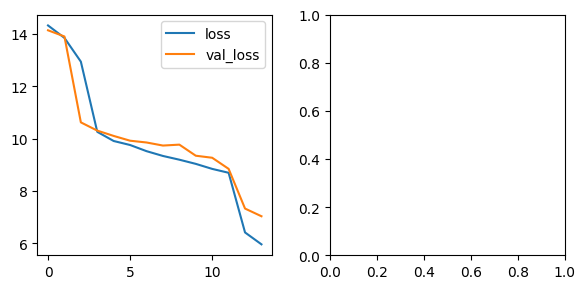

In [5]:
train_ew, val_ew = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location_nb'], shuffle=True, stride=1)
# TODO: add a form of stride that keeps all the label fields?
print(train_ew.element_spec)

model_ew = prediction_models.Dense_NN_regression(val_ew, conv1d_layers=[[32,6],[32,6]], dense_layers=[16,4],
                                                 l2_reg=0.0, mixed_dropout=0.3,
                                                 lr_scheduler=[0.003,10000,0.9],
                                                 final_activation='relu',
                                                 seed=0)

model_ew.summary()
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=15, verbose=1, plot_hist=True, callbacks=[])


In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location_nb'], shuffle=True, stride=1)
# TODO: add a form of stride that keeps all the label fields?
print(train_ns.element_spec)

model_ns = prediction_models.Dense_NN_regression(val_ns, conv1d_layers=[[32,6],[32,6],[32,6]], dense_layers=[16,4],
                                                 l2_reg=0.0, mixed_dropout=0.2,
                                                 lr_scheduler=[0.002,15000,0.9],
                                                 final_activation='relu',
                                                 seed=0)

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=20, verbose=1, plot_hist=True, callbacks=[])


In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location_nb'], shuffle=True, stride=1)
model_ns = prediction_models.Dense_NN_regression(val_ns, conv1d_layers=[[32,6],[32,6]], dense_layers=[16,4],
                                                 l2_reg=0.0, mixed_dropout=0.2,
                                                 lr_scheduler=[0.002,15000,0.9],
                                                 final_activation='relu',
                                                 seed=0)
model_ns.load_model('submission/models/ns_localizer_cnn.hdf5')
model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=10, verbose=1, plot_hist=True, callbacks=[])

In [ ]:
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=5, verbose=1, plot_hist=True, callbacks=[])

Starting training. Optimizing "val_accuracy"
Epoch 1/10


5520/5520 [==============================] - 54s 10ms/step - loss: 5.0644 - mse: 5.0644 - mae: 0.1697 - val_loss: 6.1152 - val_mse: 6.1152 - val_mae: 0.1709
Epoch 2/10
5520/5520 [==============================] - 55s 10ms/step - loss: 4.9830 - mse: 4.9830 - mae: 0.1674 - val_loss: 6.0708 - val_mse: 6.0708 - val_mae: 0.1691
Epoch 3/10
5520/5520 [==============================] - 55s 10ms/step - loss: 4.9256 - mse: 4.9256 - mae: 0.1654 - val_loss: 5.9649 - val_mse: 5.9649 - val_mae: 0.1668
Epoch 4/10
5520/5520 [==============================] - 57s 10ms/step - loss: 4.8901 - mse: 4.8901 - mae: 0.1650 - val_loss: 5.9356 - val_mse: 5.9356 - val_mae: 0.1645
Epoch 5/10
5520/5520 [==============================] - 57s 10ms/step - loss: 4.8489 - mse: 4.8489 - mae: 0.1633 - val_loss: 5.9050 - val_mse: 5.9050 - val_mae: 0.1628
Epoch 6/10
5520/5520 [==============================] - 54s 10ms/step - loss: 4.8186 - mse: 4.8186 - mae: 0.1626 - val_loss: 5.8875 - val_mse: 5.8875 - val_mae: 0.1612
Epo

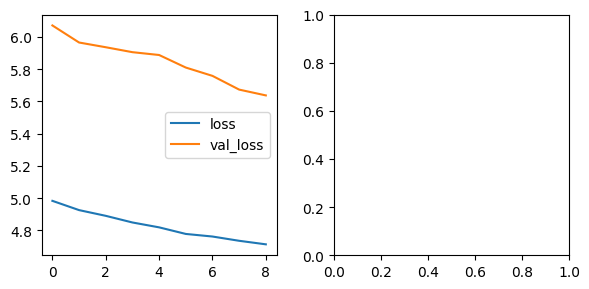

In [11]:
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=10, verbose=1, plot_hist=True, callbacks=[])

In [12]:
model_ew.model.save('submission/models/ew_localizer_cnn.hdf5')
pickle.dump(ds_gen_ew.scaler, open('submission/models/EW_localizer_scaler_cnn.pkl', 'wb'))

In [8]:
print(model_ew.model.optimizer.learning_rate)

<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.0012914015>


In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location'], shuffle=True, stride=1)

model_ns = prediction_models.Dense_NN(train_ns, conv1d_layers=[], dense_layers=[256, 128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
train_ns = train_ns.map(lambda x,y:(x,y['NS_Node_Location']))
val_ns = val_ns.map(lambda x,y:(x,y['NS_Node_Location'])) # temporary fix to allow class weights

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=20, verbose=1, plot_hist=False, class_weight={0: 0.5, 1: 20.0}, callbacks=[])
model_ns.model.save('models/ns_localizer.hdf5')

model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [12]:
#model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240115_185433-iebvf53e/files\model_iebvf53e.hdf5')
#model_ew.save('models/ew_localizer.hdf5')

model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240112_140537-85ahbucq/files\model_85ahbucq.hdf5')
# 25 6 23

In [5]:
model_ns = tf.keras.models.load_model('submission/models/ns_localizer_cnn.hdf5')


2024-01-31 16:28:00.182829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 16:28:00.203437: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 16:28:00.203510: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 16:28:00.205579: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 16:28:00.205659: I external/local_xla/xla/stream_executor

In [13]:
from base import localizer

object_limit = None

preds_df = localizer.create_prediction_df(ds_gen=ds_gen_ew,
                                model=model_ew,
                                train=False,
                                test=False,
                                output_dirs=['EW'],
                                object_limit=object_limit,
                                verbose=1)

22085/22085 [==============================] - 64s 3ms/step


In [20]:
subm_df = localizer.postprocess_predictions(preds_df=preds_df,
                                            dirs=['EW'],
                                            threshold=50.0,
                                            add_initial_node=True,
                                            clean_consecutives=True)

evaluator, sub_df = localizer.evaluate_localizer(subm_df=subm_df,
                                                 gt_path=challenge_data_dir / 'train_labels.csv',
                                                 object_ids=list(map(int, ds_gen_ew.val_keys))[:object_limit],
                                                 dirs=['EW'],
                                                 with_initial_node=False,
                                                 return_scores=False,
                                                 verbose=1)

Evaluator ignoring classifications
Precision: 0.97
Recall: 0.86
F2: 0.88
RMSE: 0.8104
TP: 568 FP: 20 FN: 89


In [6]:
evaluator, result_df = evaluation.evaluate_localizer(ds_gen_ns,
                                                    split_dataframes=split_dataframes,
                                                    gt_path=challenge_data_dir / 'train_labels.csv',
                                                    model=model_ns,
                                                    train=False,
                                                    with_initial_node=False,
                                                    remove_consecutives=True,
                                                    direction='NS',
                                                    prediction_threshold=50.0,
                                                    return_scores=False)
# 50.0: 0.96 0.78 0.81 489 22 163
# 25.0: 0.96 0.67 0.71 420 19 205
# Idea: with regression approach, instead of using consecutive detection, compute local mean values, apply 2nd threshold? somtehing like that?


2024-01-29 17:19:34.249844: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3137272320 exceeds 10% of free system memory.
2024-01-29 17:19:36.274124: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3137272320 exceeds 10% of free system memory.


25531/25531 - 59s - 59s/epoch - 2ms/step


/home/david/Code/splid-challenge/base/evaluation.py:271: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['consecutive'] = (df_filtered['TimeIndex'] - df_filtered['TimeIndex'].shift(1) != 1).cumsum()


Evaluator ignoring classifications
Precision: 0.83
Recall: 0.16
F2: 0.19
RMSE: 1.037
TP: 67 FP: 14 FN: 351


In [ ]:
pickle.dump(ds_gen_ew.scaler, open('submission/models/EW_localizer_scaler.pkl', 'wb'))

['1', '100', '101', '102', '103', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '117', '118', '12', '120', '122', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '138', '14', '140', '141', '142', '143', '144', '145', '146', '147', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '162', '163', '164', '165', '166', '168', '169', '17', '170', '172', '173', '174', '175', '177', '178', '179', '18', '180', '181', '182', '183', '186', '187', '188', '189', '19', '190', '191', '192', '194', '195', '196', '197', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '213', '214', '215', '216', '217', '218', '219', '22', '220', '223', '224', '225', '226', '228', '229', '23', '231', '232', '234', '236', '237', '239', '24', '240', '242', '243', '244', '246', '247', '248', '249', '25', '250', '27', '28', '29', '3', '31', '32', '33', '34', '35', '37', '38', '39', 

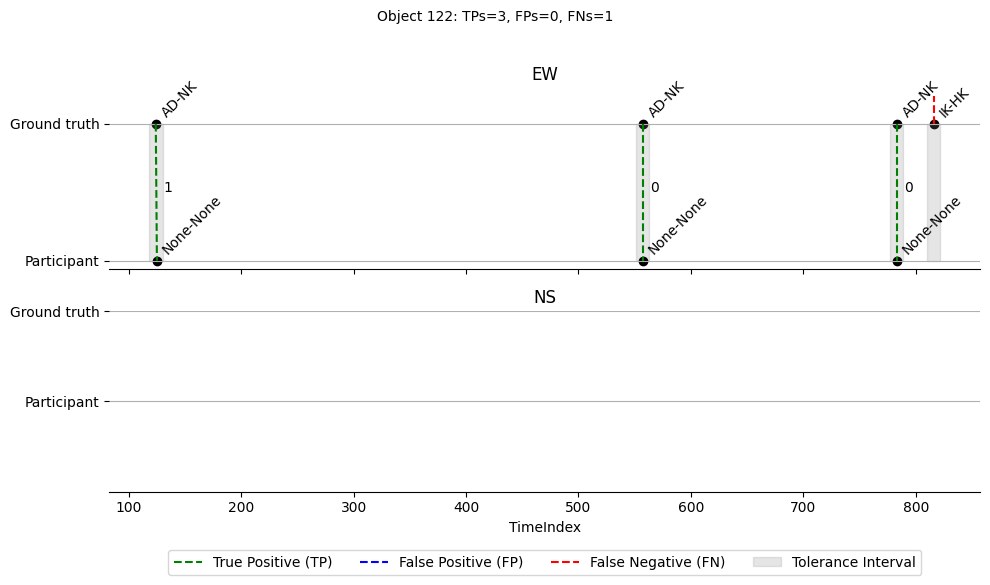

In [191]:
print(ds_gen_ew.train_keys)
evaluator.plot(122)

In [192]:
print(result_df.loc[(result_df['ObjectID'] == 122) & ((result_df['Location_Pred'] == True) | (result_df['Location'] == True))])

        ObjectID  TimeIndex  Location  Location_Pred  Location_Pred_Raw  \
207530       122        121         0              1          41.358292   
207531       122        122         0              1          72.189095   
207532       122        123         0              1          97.825836   
207533       122        124         1              1         122.176582   
207534       122        125         0              1         111.815735   
207535       122        126         0              1          71.369972   
207536       122        127         0              1          46.205509   
207537       122        128         0              1          27.297628   
207962       122        553         0              1          28.518669   
207963       122        554         0              1          71.265884   
207964       122        555         0              1         124.096207   
207965       122        556         0              1         159.353317   
207966       122        5

In [195]:
print(result_df.loc[(result_df['ObjectID'] == 122) & (result_df['TimeIndex'] >= 110) & (result_df['TimeIndex'] <= 140)])

        ObjectID  TimeIndex  Location  Location_Pred  Location_Pred_Raw  \
207519       122        110         0              0           0.074569   
207520       122        111         0              0           0.074569   
207521       122        112         0              0           0.074569   
207522       122        113         0              0           0.074569   
207523       122        114         0              0           0.074569   
207524       122        115         0              0           0.074569   
207525       122        116         0              0           0.074569   
207526       122        117         0              0           0.074569   
207527       122        118         0              0           3.679910   
207528       122        119         0              0          10.641794   
207529       122        120         0              0          24.258537   
207530       122        121         0              1          41.358292   
207531       122        1

In [20]:

direction = 'EW'
ground_truth_from_file = pd.read_csv(labels_dir)
ground_truth_from_file = ground_truth_from_file[ground_truth_from_file['ObjectID'].isin([121,122,123])].copy()
ground_truth_from_file = ground_truth_from_file[(ground_truth_from_file['Direction'] == direction)]
ground_truth_from_file = ground_truth_from_file.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)

mergeDf = ground_truth_from_file.copy()
mergeDf = mergeDf.drop([4])
mergeDf.loc[-1] = [121, 817, 'EW', 'IK', 'HK']  # adding a row
mergeDf.index = mergeDf.index + 1  # shifting index
mergeDf = mergeDf.sort_index()  # sorting by index
print(mergeDf)
print(ground_truth_from_file)

evaluator = evaluation.NodeDetectionEvaluator(ground_truth_from_file, mergeDf)
precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F2: {f2:.2f}')
print(f'RMSE: {rmse:.4}')
print(f'TP: {total_tp} FP: {total_fp} FN: {total_fn}')

    ObjectID  TimeIndex Direction Node Type
0        121        817        EW   IK   HK
1        121          0        EW   SS   NK
2        121        124        EW   AD   NK
3        121        557        EW   AD   NK
4        121        783        EW   AD   NK
6        122          0        EW   SS   NK
7        122        124        EW   AD   NK
8        122        557        EW   AD   NK
9        122        783        EW   AD   NK
10       122        816        EW   IK   HK
11       123          0        EW   SS   NK
12       123        124        EW   AD   NK
13       123        557        EW   AD   NK
14       123       1804        EW   AD   NK
    ObjectID  TimeIndex Direction Node Type
0        121          0        EW   SS   NK
1        121        124        EW   AD   NK
2        121        557        EW   AD   NK
3        121        783        EW   AD   NK
4        121        816        EW   IK   HK
5        122          0        EW   SS   NK
6        122        124        E

In [ ]:
eval_df = evaluation.localization_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True, add_initial_node=True)

2024-01-06 23:47:48.838844: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1028534400 exceeds 10% of free system memory.


In [10]:
false_preds = eval_df.loc[(eval_df['Location'] != eval_df['Location_Pred'])].sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
print(false_preds.head(80))
false_preds = eval_df[eval_df['Location'] != eval_df['Location_Pred']]
print(len(false_preds))
print(len(eval_df))

    ObjectID  TimeIndex  Location  Location_Pred Node Type Direction
0        106         69         0              1   AD   NK        EW
1        108        179         0              1   SS   NK        EW
2        114        201         0              1   AD   NK        EW
3        116        201         0              1   AD   NK        EW
4        117        461         0              1   AD   NK        EW
5        123        125         0              1   AD   NK        EW
6        124        367         0              1   AD   NK        EW
7        129        972         1              0   IK   CK        EW
8        130         86         1              0   IK   CK        EW
9        131        155         0              1   AD   NK        EW
10       135        936         1              0   IK   CK        EW
11       139       1009         1              0   AD   NK        EW
12       139       1098         1              0   IK   CK        EW
13       141        157         1 